In [1]:
import pymysql

import pandas as pd
import logging
import warnings
warnings.filterwarnings("ignore")

import os
import sys
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

import numpy as np
np.random.seed(42)

from datetime import datetime, timedelta
import pickle

def mape_not_zero(y_true, y_pred):
    mape = 0
    for t, p in zip(y_true, y_pred):
        if t != 0:
            mape += np.abs((t - p) / t)
        elif p != 0:
            mape += np.abs((t - p) / p)

    mape /= len(y_true)
    return np.mean(mape) * 100

def rmse(y_true, y_pred):
    mse = (np.square(y_true - y_pred)).mean(axis=0)
    return np.sqrt(mse) 

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df = pd.read_csv("/Users/kjh001/z_eggo/weather.csv", encoding='cp949')
scale_cols=['temp','humi','wind','vol']
df_scaled=scaler.fit_transform(df[scale_cols])


df_scaled=pd.DataFrame(df_scaled)
df_scaled.columns=scale_cols
print(df_scaled)


          temp    humi      wind       vol
0     0.200000  0.5625  0.289941  0.243946
1     0.200000  0.5625  0.289941  0.244930
2     0.200000  0.5625  0.289941  0.251231
3     0.200000  0.5625  0.289941  0.244733
4     0.155556  0.6875  0.106509  0.240992
...        ...     ...       ...       ...
8755  0.177778  0.5625  0.195266  0.011223
8756  0.177778  0.5625  0.195266  0.012404
8757  0.177778  0.5625  0.195266  0.011223
8758  0.155556  0.6875  0.153846  0.011026
8759  0.155556  0.6875  0.153846  0.010238

[8760 rows x 4 columns]


In [3]:
train=df_scaled[:7008]
test=df_scaled[7008:]

In [4]:
def make_dataset(data,label,size=2):
    feature_list=[]
    label_list=[]
    for i in range(len(data)-size):
        feature_list.append(np.array(data.iloc[i:i+size]))
        label_list.append(np.array(label.iloc[i+size]))
    return np.array(feature_list),np.array(label_list)

In [5]:
feature_cols=['temp','humi','wind']
label_cols=['vol']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature,train_label,2)

from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid=train_test_split(train_feature,train_label,test_size=0.2)
print(x_train.shape, x_valid.shape)

test_feature, test_label = make_dataset(test_feature,test_label,2)
print(test_feature.shape, test_label.shape)

(5604, 2, 3) (1402, 2, 3)
(1750, 2, 3) (1750, 1)


In [6]:
model=Sequential()
model.add(LSTM(32,
               input_shape=(train_feature.shape[1],train_feature.shape[2]),
               activation='relu',return_sequences=False))
model.add(Dense(1))
model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


2022-05-25 00:15:01.486394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 00:15:01.486503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.compile(loss='mse',optimizer='adam')
early_stop=EarlyStopping(monitor='val_loss',patience=10,verbose=1)
history=model.fit(x_train,y_train,epochs=100,
                  batch_size=2, verbose=1,
                  validation_data=(x_valid,y_valid),
                  callbacks=[early_stop])

Epoch 1/100


2022-05-25 00:15:01.640945: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-25 00:15:02.193148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2801/2802 [============================>.] - ETA: 0s - loss: 0.0049

2022-05-25 00:15:43.788857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2802/2802 [==============================] - 46s 16ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 2/100
2802/2802 [==============================] - 61s 22ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 3/100
2802/2802 [==============================] - 64s 23ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 4/100
2802/2802 [==============================] - 73s 26ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/100
2802/2802 [==============================] - 69s 25ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 6/100
2802/2802 [==============================] - 67s 24ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 7/100
2802/2802 [==============================] - 69s 25ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 8/100
2802/2802 [==============================] - 75s 27ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 9/100
2802/2802 [==============================] - 91s 32ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/100
2802/2802 [==============================] - 92s 33ms/

In [8]:
testmse = model.evaluate(test_feature, test_label, batch_size=2)
testmse

875/875 [==============================] - 9s 11ms/step - loss: 0.0213


0.0213068425655365

In [9]:
pred=model.predict(test_feature,batch_size=2)

2022-05-25 01:00:21.218489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


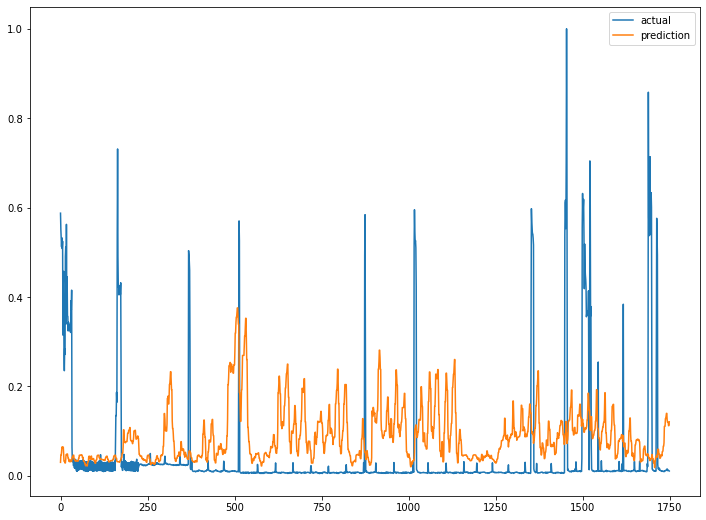

In [13]:
plt.figure(figsize=(12,9))
plt.plot(test_label,label='actual')
plt.plot(pred,label='prediction')
plt.legend()
plt.show()

In [11]:
pkl_path = "model/model_rnn_eggo_lstm.pkl"
with open(pkl_path, "wb") as f:
    pickle.dump(model, f)

2022-05-25 14:11:47.717193: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e87abf07-7fb3-42c0-ba2c-c253339ee569/assets
